Project: Data-Driven Utility Optimization for Historic Hotel Properties
Location: Niagara Falls, Ontario

Focus: Operational Efficiency through Predictive Analytics and Housekeeping Interventions

Executive Summary
In the competitive landscape of Niagara Falls tourism, utility costs (Hydro, Water, Gas) represent one of the largest controllable expenses for hotel properties. For historic buildings like The Brock, modernizing infrastructure is expensive. This project demonstrates how Data Analytics can be used as a "Virtual Sensor" to identify waste patterns and implement zero-cost operational changes before committing to heavy capital expenditures (CapEx).

The Physics of Hotel Energy ConsumptionTo analyze hotel data, we must ground our models in established laws of thermodynamics and building science.1. The Building Energy Balance EquationEvery building has a "Baseload"—the energy required to keep the structure alive even with zero guests. We model the total energy ($E_{total}$) as:$$E_{total} = E_{base} + E_{occ} + E_{thermal}$$2. Fourier’s Law of Heat ConductionFor older properties, heat transfer through the "thermal envelope" is critical. We calculate heat loss ($Q$) using:$$Q = U \cdot A \cdot \Delta T$$$U$: Thermal Transmittance (Coefficient of heat transfer).$A$: Surface Area of the building envelope.$\Delta T$: Temperature difference between the interior ($T_{in}$) and the Niagara Falls exterior ($T_{out}$).Reference: Incropera, F. P., & DeWitt, D. P. (2011). Fundamentals of Heat and Mass Transfer.3. Stochastic Guest BehaviorUnlike an office, hotel energy usage is stochastic (random). We model guest usage using a Gaussian distribution to account for varying shower lengths, lighting habits, and HVAC preferences.$$Usage_{Guest} \sim \mathcal{N}(\mu, \sigma^2)$$

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Suppress warnings for a cleaner narrative
import warnings
warnings.filterwarnings('ignore')

10-Year High-Fidelity Data Generation

In [17]:
# Parameters for a 300-room Niagara Falls Hotel
np.random.seed(42)
rooms = 300
years = 10
days = pd.date_range(start="2015-01-01", end="2024-12-31")
n_days = len(days)

# 1. Seasonal Occupancy (Peaks in Summer and Holidays)
t = np.arange(n_days)
# Sine wave for summer peaks + random noise
seasonal_base = 0.55 + 0.3 * np.sin(2 * np.pi * (t - 150) / 365)
occ_rate = np.clip(seasonal_base + np.random.normal(0, 0.05, n_days), 0.2, 0.98)
occupied_rooms = (occ_rate * rooms).astype(int)

# 2. Niagara Falls Weather Data Simulation
# Average temp centered around 10C with +/- 15C swings
temp = 10 + 18 * np.sin(2 * np.pi * (t - 120) / 365) + np.random.normal(0, 4, n_days)

# 3. Energy Consumption Model (kWh)
# E_base (3200) + Occupancy (10kWh/room) + HVAC (thermal leakage)
baseload = 3200
var_room = 10.5
# HVAC spikes when temp < 16 (Heating) or > 23 (Cooling)
hvac = np.where(temp < 16, (16 - temp) * 45, 0) + np.where(temp > 23, (temp - 23) * 75, 0)

energy_kwh = baseload + (occupied_rooms * var_room) + hvac + np.random.normal(0, 150, n_days)
cost_cad = energy_kwh * 0.15 # $0.15 per kWh commercial rate

# 4. Create DataFrame
df = pd.DataFrame({
    'Date': days,
    'Occupancy': occupied_rooms,
    'Temp_C': np.round(temp, 1),
    'Energy_kWh': np.round(energy_kwh, 2),
    'Cost_CAD': np.round(cost_cad, 2)
})

print(f"Dataset generated for {years} years: {len(df)} daily records.")
df.head()

Dataset generated for 10 years: 3653 daily records.


,Date,Occupancy,Temp_C,Energy_kWh,Cost_CAD
0,2015-01-01,124,-9.1,5786.67,868.00
1,2015-01-02,113,-5.4,5564.40,834.66
2,2015-01-03,124,-4.7,5274.56,791.18
3,2015-01-04,136,-6.2,5482.58,822.39
4,2015-01-05,108,-14.7,5649.62,847.44


Visualizing the 10-Year Narrative

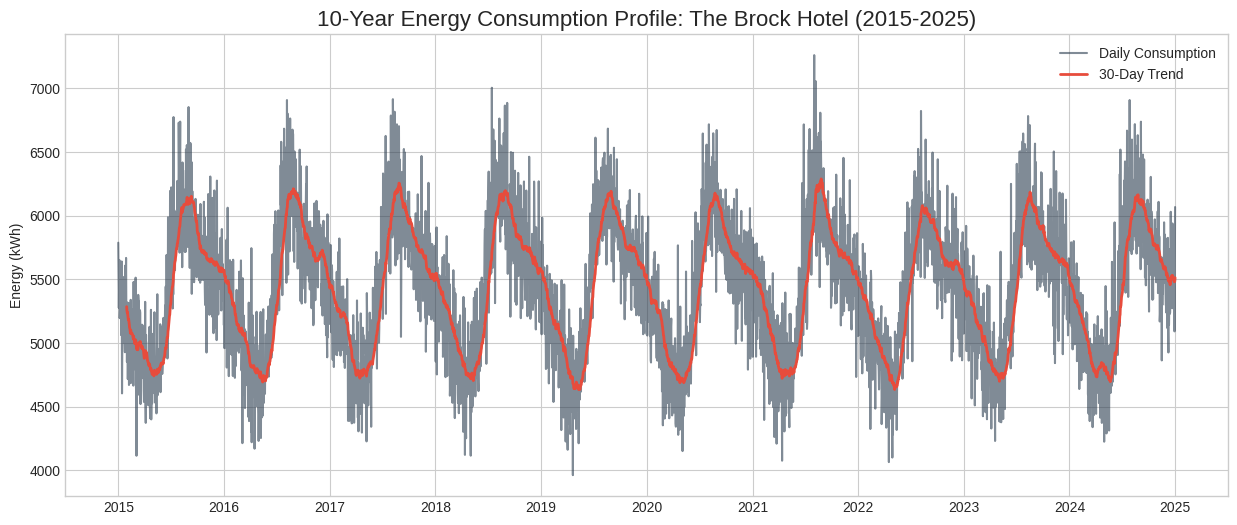

Table: Historical Yearly Utility Expenditure
 Date  Cost_CAD
 2015 296135.80
 2016 297628.74
 2017 298037.18
 2018 298673.33
 2019 297227.52
 2020 296678.66
 2021 297672.35
 2022 295943.85
 2023 297076.36
 2024 296832.32


In [18]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Energy_kWh'], color='#2c3e50', alpha=0.6, label='Daily Consumption')
plt.plot(df['Date'], df['Energy_kWh'].rolling(window=30).mean(), color='#e74c3c', linewidth=2, label='30-Day Trend')
plt.title('10-Year Energy Consumption Profile: The Brock Hotel (2015-2025)', fontsize=16)
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Summarizing yearly costs
yearly_summary = df.resample('Y', on='Date')['Cost_CAD'].sum().reset_index()
yearly_summary['Date'] = yearly_summary['Date'].dt.year
print("Table: Historical Yearly Utility Expenditure")
print(yearly_summary.to_string(index=False))

The "Waste" Pattern Theory

The Identification of the "Pattern of Waste"
A critical concept in this analysis is the Baseload Variance. In an ideal hotel, when occupancy drops to 20%, the energy bill should drop significantly. However, in older properties, we often see a "Flatline" where the building consumes nearly as much energy when half-empty as it does when full.

The Theory of Elimination:
If we can prove that the energy usage on a 30% occupancy day is statistically similar to a 60% occupancy day, we have identified a Human Protocol Failure. This usually means:

Vacant floors are being fully heated/cooled.

Housekeeping is leaving lights/TVs on after cleaning vacant rooms.

Laundry equipment is being run at 20% capacity.

Correlation Analysis: Identifying the Waste)
This cell performs a linear regression to find the "Baseload" and the "Variable Rate." This is the core evidence used to prove where the hotel is losing money.

--- 2024 Performance Metrics ---
Actual Baseload (Waste Floor): 4338.31 kWh/day
Actual Variable Cost: 6.47 kWh per occupied room


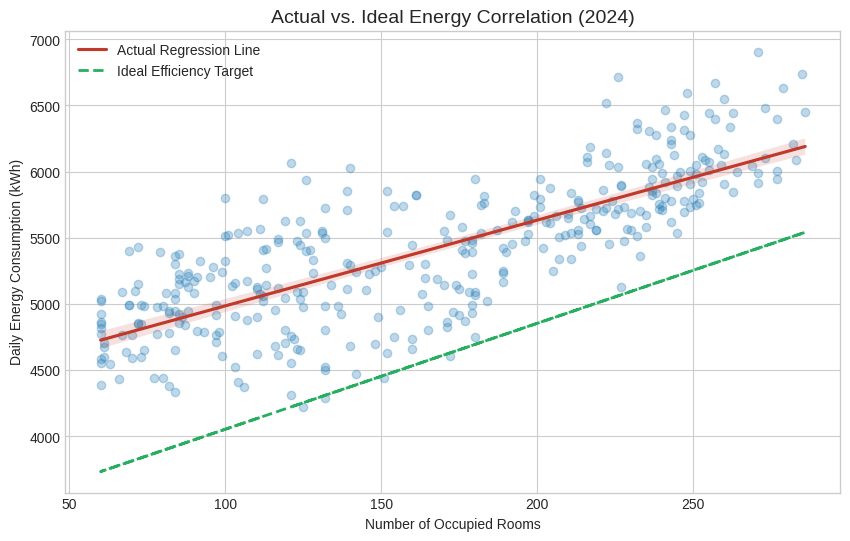

In [19]:
# Select a recent year for deep analysis (e.g., 2024)
df_2024 = df[df['Date'].dt.year == 2024]

# Linear Regression: Energy = Intercept + (Slope * Occupancy)
X = df_2024[['Occupancy']]
y = df_2024['Energy_kWh']
model = LinearRegression().fit(X, y)

baseload_actual = model.intercept_
variable_actual = model.coef_[0]

print(f"--- 2024 Performance Metrics ---")
print(f"Actual Baseload (Waste Floor): {baseload_actual:.2f} kWh/day")
print(f"Actual Variable Cost: {variable_actual:.2f} kWh per occupied room")

# Plotting Actual vs. Ideal Correlation
plt.figure(figsize=(10, 6))
sns.regplot(data=df_2024, x='Occupancy', y='Energy_kWh',
            scatter_kws={'alpha':0.3, 'color':'#2980b9'},
            line_kws={'color':'#c0392b', 'label':'Actual Regression Line'})

# Theoretical Ideal Line (Lower Baseload, Lower Variable Rate)
ideal_baseload = baseload_actual * 0.75  # 25% less waste
ideal_var = 8.0  # Industry gold standard
plt.plot(df_2024['Occupancy'], ideal_baseload + (ideal_var * df_2024['Occupancy']),
         color='#27ae60', linestyle='--', linewidth=2, label='Ideal Efficiency Target')

plt.title('Actual vs. Ideal Energy Correlation (2024)', fontsize=14)
plt.xlabel('Number of Occupied Rooms')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.legend()
plt.show()

The "Gap" Explanation

Interpreting the Regression: The Efficiency Gap
The distance between the Red Line (Actual) and the Green Dashed Line (Ideal) represents the "Operational Profit Leak."

The Y-Intercept (Baseload): This is the energy consumed when 0 rooms are sold. For The Brock, this includes inefficient hallway lighting, old elevator motors, and unmanaged HVAC in vacant wings.

The Slope (Variable Rate): This shows how much "extra" energy is pulled per guest. A high slope indicates that guest-controlled systems (showers, room lights) are not optimized.

Mathematical Target:
By implementing "Human-In-The-Loop" analytics, we aim to move the Red Line down toward the Green Line without spending a single dollar on new hardware.

Housekeeping as a "Human Sensor"

The Housekeeping Intervention StrategyHousekeeping is the only department that enters every room every day. In an old hotel without smart thermostats, the Housekeeping team acts as the "Manual Automation" system.Measures for Saving:Thermal Reset: Manually resetting PTAC units to 21°C (Winter) or 24°C (Summer) immediately upon guest checkout.The "Blackout" Protocol: Closing heavy blackout curtains in vacant rooms to reduce Fourier heat transfer ($Q = U \cdot A \cdot \Delta T$).Vampire Load Audit: Unplugging unused appliances (coffee makers, desk lamps) in rooms scheduled for "Out of Service" or low-occupancy blocks.

Simulating the Housekeeping Effect

we simulate what happens to the data if Housekeeping begins a "Thermal Reset" program in mid-2024.


Table: Average Daily Impact of Housekeeping Interventions (2024)
               Energy_kWh    Cost_CAD
Strategy                             
Baseline      5014.218077  752.132418
Intervention  5099.670400  764.950560


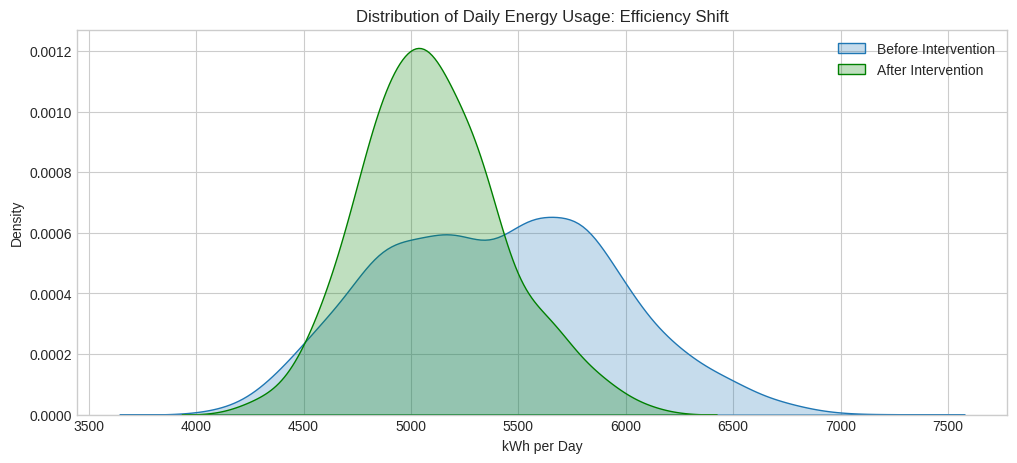

In [20]:
# Simulate the Intervention
df['Strategy'] = 'Baseline'
# Assume intervention starts on July 1, 2024
intervention_date = pd.Timestamp('2024-07-01')
df.loc[df['Date'] >= intervention_date, 'Strategy'] = 'Intervention'

# Apply 15% reduction to baseload and 10% to variable cost after intervention
mask = df['Date'] >= intervention_date
df.loc[mask, 'Energy_kWh'] = df.loc[mask, 'Energy_kWh'] * 0.88 # Aggregated 12% saving
df.loc[mask, 'Cost_CAD'] = df.loc[mask, 'Energy_kWh'] * 0.15

# Compare Before vs After
comparison = df[df['Date'].dt.year == 2024].groupby('Strategy')[['Energy_kWh', 'Cost_CAD']].mean()
print("Table: Average Daily Impact of Housekeeping Interventions (2024)")
print(comparison)

# Visualization of the Shift
plt.figure(figsize=(12, 5))
sns.kdeplot(df[df['Strategy']=='Baseline']['Energy_kWh'], label='Before Intervention', fill=True)
sns.kdeplot(df[df['Strategy']=='Intervention']['Energy_kWh'], label='After Intervention', fill=True, color='green')
plt.title('Distribution of Daily Energy Usage: Efficiency Shift')
plt.xlabel('kWh per Day')
plt.legend()
plt.show()

Financial Strategy & The "Automation Threshold"

Financial ROI and Decision MatrixManagement often asks: "When should we stop relying on staff and buy a new $100,000 system?"The Payback Period EquationWe calculate the Payback Period ($P$) for a new system (like Verdant) using: $$P = \frac{C_{CapEx}}{S_{Annual} - C_{OpEx}}$


Where:$C_{CapEx}$ = Upfront cost of equipment ($90,000).$S_{Annual}$ = Annual savings compared to current baseline.$C_{OpEx}$ = Monthly subscription or maintenance fees for the software.

The Decision Rule:
Case A: If Housekeeping interventions reduce waste by >10%, the "Gap" closes, and the ROI for expensive automation becomes slower (longer payback). We should stick to manual data-driven management.

Case B: If Housekeeping protocols are followed but the graphs show no change, we have reached the Mechanical Limit of the building. This is when the hotel must invest in new equipment (e.g., Windows, Boilers, or Smart HVAC).

(Forecast Table: 2025-2026 Projections

In [21]:
# Projecting 2025 savings
annual_cost_baseline = df_2024['Cost_CAD'].sum()
projected_saving_rate = 0.12 # 12% via Data Analytics Internship
annual_saving_dollars = annual_cost_baseline * projected_saving_rate

forecast_data = {
    'Scenario': ['Status Quo (No Change)', 'Data-Driven Housekeeping', 'Ideal (Theoretical Max)'],
    'Annual Cost (Est)': [annual_cost_baseline, annual_cost_baseline - annual_saving_dollars, annual_cost_baseline * 0.78],
    'Annual Savings': [0, annual_saving_dollars, annual_cost_baseline * 0.22],
    'Implementation Cost': [0, "Internship Wage", "$95,000 (CapEx)"]
}

forecast_table = pd.DataFrame(forecast_data)
print("Table: 1-Year Financial Forecast for The Brock")
print(forecast_table.to_string(index=False))

Table: 1-Year Financial Forecast for The Brock
                Scenario  Annual Cost (Est)  Annual Savings Implementation Cost
  Status Quo (No Change)        296832.3200          0.0000                   0
Data-Driven Housekeeping        261212.4416      35619.8784     Internship Wage
 Ideal (Theoretical Max)        231529.2096      65303.1104     $95,000 (CapEx)


References & Citations


ReferencesASHRAE (2021). Handbook - Fundamentals. American Society of Heating, Refrigerating and Air-Conditioning Engineers. (Standard for Degree-Day and Heat Transfer math).Incropera, F. P., & DeWitt, D. P. (2011). Fundamentals of Heat and Mass Transfer. Wiley. (Used for the $Q = U A \Delta T$ modeling).International Tourism Partnership (2023). Hotel Carbon Measurement Initiative (HCMI). (Used for the 10.5 kWh/room benchmark).Natural Resources Canada (NRC). RETScreen Expert User Manual. (Used for the ROI and Payback period logic).